In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pdb
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avichanales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

import spacy
nlp  = spacy.load('en_core_web_md')

## 0.0 Load Data

In [5]:
file_name = '/Users/avichanales/Dropbox/Insight/Project/insight_project/data/interim/charity_data_cleaned.csv'
all_charity = pd.read_csv(file_name)

In [6]:
test = all_charity[['name','score']].head()

## 1.0 Pre-process raw text (lamentize and remove stopwords) 

In [7]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            #result.append(lemmatize_stemming(token))
            result.append(token)
            
    return result

def preprocess_docs(docs):
    result = []
    
    for doc in docs:
        result.append(preprocess(doc))
    
    return result

In [90]:
def preprocess_spacy(raw_text):
    
    doc = nlp(raw_text)
    
    #Remove organizations and people from documnet text
    tokens_ner = [entity.text for entity in doc.ents if entity.label_ in {'DATE', 'PERSON', 'ORG','MONEY'}]

    for term in tokens_ner:
        raw_text = raw_text.replace(term,"")
    
    #Re-convert preprocessed text to spacy object    
    doc = nlp(raw_text)


    #Remove stopwords and lemmatize
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct or token.shape_ == 'dd')]
    return tokens

def preprocess_docs(docs):
    result = []
    
    for doc in docs:
        result.append(preprocess_spacy(doc))
    
    return result

In [92]:
all_charity['description_noname'] = all_charity.apply(lambda x: x['description'].replace(x['name'],""),axis=1)

In [93]:
mission_text = all_charity['description_noname'].astype('str')

#Preprocess mission descriptions
mission_text_pre = preprocess_docs(mission_text)

In [166]:
all_charity['category'].unique()

array(['Environment', 'Arts, Culture, Humanities', 'Human Services',
       'Education', 'Animals', 'International', 'Health',
       'Human and Civil Rights', 'Research and Public Policy',
       'Community Development'], dtype=object)

In [150]:
from sklearn.feature_extraction.text import CountVectorizer
import re

In [158]:
corpus = []
stop_words = set(stopwords.words("english"))
for i in range(0, 3847):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', all_charity['description_noname'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

                   Bi-gram  Freq
0             young people   308
1             united state   226
2               low income   210
3                 new york   193
4               non profit   179
5              health care   175
6             quality life   169
7             child family   166
8             around world   142
9          program service   135
10          full potential   134
11     educational program   116
12       individual family   113
13               men woman   111
14                boy girl   110
15             woman child   109
16       education program   108
17  nonprofit organization   106
18        self sufficiency   106
19       domestic violence   106
20               york city   103
21         mission provide   102
22  organization dedicated   101
23             high school    99
24               long term    98
25             child adult    97
26          performing art    92
27            high quality    92
28          social service    90
29     pro

[Text(0,0,'young people'),
 Text(0,0,'united state'),
 Text(0,0,'low income'),
 Text(0,0,'new york'),
 Text(0,0,'non profit'),
 Text(0,0,'health care'),
 Text(0,0,'quality life'),
 Text(0,0,'child family'),
 Text(0,0,'around world'),
 Text(0,0,'program service'),
 Text(0,0,'full potential'),
 Text(0,0,'educational program'),
 Text(0,0,'individual family'),
 Text(0,0,'men woman'),
 Text(0,0,'boy girl'),
 Text(0,0,'woman child'),
 Text(0,0,'education program'),
 Text(0,0,'nonprofit organization'),
 Text(0,0,'self sufficiency'),
 Text(0,0,'domestic violence'),
 Text(0,0,'york city'),
 Text(0,0,'mission provide'),
 Text(0,0,'organization dedicated'),
 Text(0,0,'high school'),
 Text(0,0,'long term'),
 Text(0,0,'child adult'),
 Text(0,0,'performing art'),
 Text(0,0,'high quality'),
 Text(0,0,'social service'),
 Text(0,0,'profit organization'),
 Text(0,0,'community based'),
 Text(0,0,'food bank'),
 Text(0,0,'ronald mcdonald'),
 Text(0,0,'los angeles'),
 Text(0,0,'life skill'),
 Text(0,0,'year

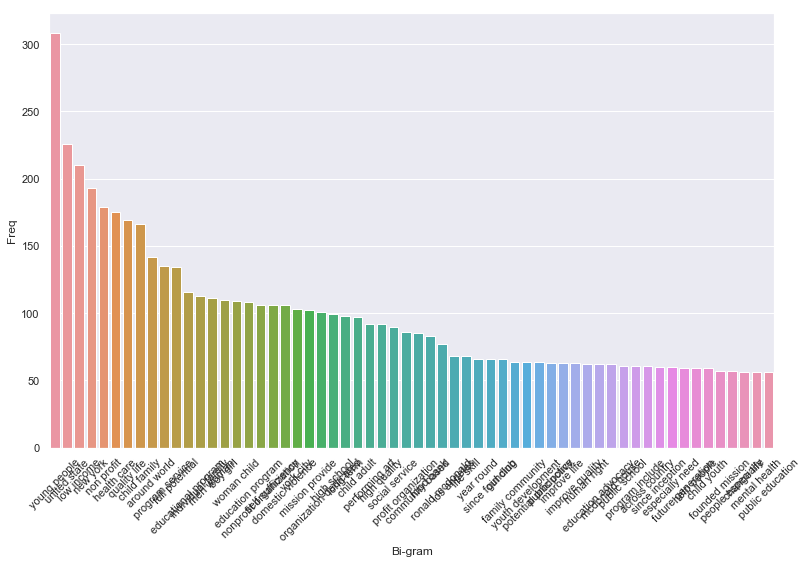

In [163]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(corpus, n=60)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)


#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                         Tri-gram  Freq
0                   new york city   103
1         non profit organization    73
2                   boy girl club    66
3       full potential productive    63
4           ronald mcdonald house    62
5         young people especially    56
6            reach full potential    54
7            improve quality life    52
8          people especially need    52
9             enable young people    49
10         realize full potential    48
11                men woman child    42
12              boy scout america    42
13                 home away home    39
14              young people make    37
15      lifetime instilling value    35
16                 scout oath law    35
17  productive responsible caring    35
18              low income family    34
19         instilling value scout    34


[Text(0,0,'new york city'),
 Text(0,0,'non profit organization'),
 Text(0,0,'boy girl club'),
 Text(0,0,'full potential productive'),
 Text(0,0,'ronald mcdonald house'),
 Text(0,0,'young people especially'),
 Text(0,0,'reach full potential'),
 Text(0,0,'improve quality life'),
 Text(0,0,'people especially need'),
 Text(0,0,'enable young people'),
 Text(0,0,'realize full potential'),
 Text(0,0,'men woman child'),
 Text(0,0,'boy scout america'),
 Text(0,0,'home away home'),
 Text(0,0,'young people make'),
 Text(0,0,'lifetime instilling value'),
 Text(0,0,'scout oath law'),
 Text(0,0,'productive responsible caring'),
 Text(0,0,'low income family'),
 Text(0,0,'instilling value scout')]

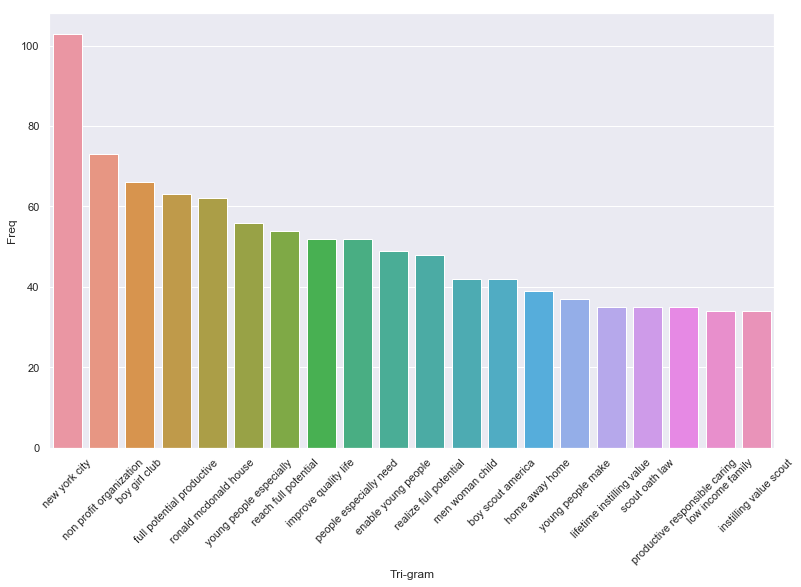

In [165]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

## 2.0 Convert pre-processed text to vectors and embed

In [94]:
def word_embed_charity_tfidf(processed_docs,word_min=5, word_max_perc=.2):
    
    'Assumes docs have already been pre-processed'
    
    #Create dictionary from corpus
    docs_dict = Dictionary(processed_docs)
    docs_dict.filter_extremes(no_below=word_min, no_above=word_max_perc)
    docs_dict.compactify()
    
    #Convert docs into tf-idf vectors
    docs_corpus = [docs_dict.doc2bow(doc) for doc in processed_docs]
    model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
    docs_tfidf  = model_tfidf[docs_corpus]
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])
    
    num_docs= np.shape(docs_vecs)[0]
    num_words = np.shape(docs_vecs)[1]

    print("Total # of docs: {}".format(num_docs))
    print("Total # of words in dict: {}".format(num_words))
    
    #For each word in dict obtain embedding vector (Glove vectors)
    tfidf_emb_vecs = np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))])
    
    # Weight glove vectors by tf-idf values
    docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 
        
    return docs_emb, docs_dict, model_tfidf, tfidf_emb_vecs, docs_tfidf

In [142]:
def word_embed_charity_notfidf(processed_docs,word_min=5, word_max_perc=.8 ):
    
    'Assumes docs have already been pre-processed'
    
    #Create dictionary from corpus
    docs_dict = Dictionary(processed_docs)
    docs_dict.filter_extremes(no_below=word_min, no_above=word_max_perc)
    docs_dict.compactify()
    
    #Convert docs into tf-idf vectors
    docs_corpus = [docs_dict.doc2bow(doc) for doc in processed_docs]
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_corpus])
    
    num_docs= np.shape(docs_vecs)[0]
    num_words = np.shape(docs_vecs)[1]

    print("Total # of docs: {}".format(num_docs))
    print("Total # of words in dict: {}".format(num_words))
    
    #For each word in dict obtain embedding vector (Glove vectors)
    emb_vecs = np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))])
    
    # Sum glove vectors over words in doc
    docs_emb = np.dot(docs_vecs, emb_vecs) 
        
    return docs_emb, docs_dict, emb_vecs

In [148]:
word_min = 0
word_max_perc = .5
charity_docs_emb, charity_docs_dict, charity_model_tfidf, charity_tfidf_emb_vecs, charity_docs_tfidf = word_embed_charity_tfidf(mission_text_pre,
                                                                                                            word_min=word_min, 
                                                                                                            word_max_perc=word_max_perc)




Total # of docs: 5637
Total # of words in dict: 12603


In [149]:
#Store output in dictionary and save
charity_model_dict = {'charity_docs_emb': charity_docs_emb, 
                      'charity_docs_dict': charity_docs_dict,
                      'charity_model_tfidf': charity_model_tfidf,
                     'charity_tfidf_emb_vecs': charity_tfidf_emb_vecs}

with open('/Users/avichanales/Dropbox/Insight/Project/insight_project/data/processed/charity_model_min_{}_max_{}.pickle'.format(word_min,word_max_perc), 'wb') as handle:
    pickle.dump(charity_model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [144]:
word_min = 0
word_max_perc = .5
charity_docs_emb, charity_docs_dict, charity_emb_vecs = word_embed_charity_notfidf(mission_text_pre,word_min=word_min,word_max_perc=word_max_perc)


Total # of docs: 5637
Total # of words in dict: 12603


In [147]:
#Store output in dictionary and save
charity_model_dict = {'charity_docs_emb': charity_docs_emb, 
                      'charity_docs_dict': charity_docs_dict,
                       'charity_emb_vecs': charity_emb_vecs}

with open('/Users/avichanales/Dropbox/Insight/Project/insight_project/data/processed/charity_model_min_{}_max_{}_notfidf.pickle'.format(word_min,word_max_perc), 'wb') as handle:
    pickle.dump(charity_model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [130]:
def getKey(item):
    return item[1]

def find_keywords(all_charity,charity_name,charity_docs_dict,charity_docs_tfidf,mission_text_pre,n=10):
    'Funciton to find top n keywords in mission statement based on tfidf'
    
    
    #Get index of charity
    idx = all_charity[all_charity.name == charity_name].index.values.astype(int)[0]
    
    #Sort words from mission statement by tfidf values
    s = sorted(charity_docs_tfidf[idx],key=getKey,reverse=True)
    
    # Return indices of top N words with highest tfidf values
    topn_tfidf_values = [s[i][0] for i in range(0,n)]
    
    # Look up words in mission statement
    topn_words = [charity_docs_dict[i] for i in topn_tfidf_values]
    
    # Return mission statement
    mission_statement = mission_text_pre[idx]
    
    return topn_words, mission_statement

In [135]:
topn_words, mission_statement = find_keywords(all_charity,'Friends of the Earth',charity_docs_dict, charity_docs_tfidf,mission_text_pre,15)

In [136]:
topn_words

['fight',
 'protect',
 'campaign',
 'grassroots',
 'harmful',
 'potentially',
 'warming',
 'toxic',
 'pollution',
 'network',
 'International',
 'world',
 'smart',
 'planet',
 'healthy']

In [126]:
mission_statement

[' ',
 'formally',
 'establish',
 ' ',
 'local',
 'pastor',
 'recognize',
 'necessity',
 'permanent',
 'ministry',
 'effort',
 'meet',
 'need',
 'grow',
 'population',
 'homeless',
 'Knoxville',
 'man',
 'forge',
 'vision',
 'establish',
 'ministry',
 'center',
 'locate',
 'heart',
 'downtown',
 'area',
 'Fifth',
 'Avenue',
 'today',
 ' ',
 'equipped',
 'prepared',
 'fulfill',
 'mandate',
 'pledge',
 'hurt',
 'homeless',
 'great',
 'Knoxville',
 'area',
 'mission',
 'seek',
 'rescue',
 'poor',
 'needy',
 'Knox',
 'Area',
 'provide',
 'service']

In [112]:
mission_statement[47]

'healthy'

In [31]:
def getKey(item):
    return item[1]
s = sorted(charity_docs_tdidf[0],key=getKey,reverse=True)


In [43]:
top5 = [s[i][0] for i in range(0,10)]

In [44]:
top5

[10, 0, 7, 8, 14, 4, 15, 11, 5, 12]

In [45]:
top5_words = [mission_text_pre[0][i] for i in top5]

In [46]:
top5_words

['protect',
 'work',
 'urban',
 'rural',
 'conserve',
 'life',
 'natural',
 'family',
 'build',
 'farm']

## 4.0 Preprocess Headline

In [159]:
def process_embed_text(text,charity_docs_dict,charity_model_tfidf,charity_tfidf_emb_vecs):
    
    text_pre = preprocess_spacy(text)
     
    #Convert docs into tf-idf vectors
    doc_corpus = charity_docs_dict.doc2bow(text_pre)
    doc_tfidf  = charity_model_tfidf[doc_corpus]
    doc_vec   = np.vstack([sparse2full(doc_tfidf, len(charity_docs_dict))])
    
    # sum of glove vectors linearlly weighted by tfidf 
    art_emb = np.dot(doc_vec, charity_tfidf_emb_vecs)
    
    
    return art_emb

In [160]:
def compute_similarity_output_n(art_emb,charity_docs_emb,topn):
    
    #compute cosine distance from article embedding to all charities
    sim_to_charities = cosine_similarity(art_emb,charity_docs_emb)
    
    #find topN similarity scores
    sim_scores_sorted = -np.sort(-sim_to_charities).flatten()
    topN_scores = sim_scores_sorted[:topn]
    
    #find topN indices
    indices_sorted = (-sim_to_charities).argsort().flatten()
    topN_indices = indices_sorted[:topn].flatten()
    
    return topN_scores, topN_indices
    
    

In [161]:
def topN_ranked_charities(charity_df, topN_scores, topN_indices):
    
    charity_df_slim = charity_df[['name','subcategory','score','description']]
    
    #Extract topN charities and info
    similar_charities = charity_df_slim.iloc[topN_indices].reset_index()
    
    #Add their similarity scores
    similar_charities['sim_score'] = topN_scores
    
    return similar_charities

In [174]:
text = 'Greta Thunberg became a climate activist not in spite of her autism, but because of it'

In [175]:
art_emb = process_embed_text(text,charity_docs_dict,charity_model_tfidf,charity_tfidf_emb_vecs)

In [176]:
topN_scores, topN_indices = compute_similarity_output_n(art_emb,charity_docs_emb,3)
topN_charities = topN_ranked_charities(all_charity, topN_scores, topN_indices)

In [177]:
topN_charities

,index,name,subcategory,score,description,sim_score
0,2858,The Austin Community in Action,Patient and Family Support,85.09,The Autism Community in Action (TACA) formerly...,0.717931
1,4458,Doug Flutie Jr. Foundation For Autism,"Diseases, Disorders, and Disciplines",87.31,The Doug Flutie Jr. Foundation For Autism's go...,0.712984
2,3952,Climate Central,Environmental Protection and Conservation,84.53,Climate Central works to communicate the scien...,0.693686
3,2347,Turning Pointe Autism Foundation,Patient and Family Support,94.74,Turning Pointe Autism Foundation was founded i...,0.690892
4,4679,ecoAmerica,Environmental Protection and Conservation,88.77,"ecoAmerica builds institutional leadership, pu...",0.676833
5,492,Lewy Body Dementia Association,Patient and Family Support,89.94,"Through outreach, education and research, we s...",0.670822
6,4795,FRAXA Research Foundation,Medical Research,97.17,FRAXA Research Foundation was founded in 1994 ...,0.668610
7,1175,National Center for Transgender Equality,Advocacy and Education,83.37,The National Center for Transgender Equality (...,0.668078
8,1194,National Alliance for the Mentally Ill of New ...,"Diseases, Disorders, and Disciplines",87.19,The National Alliance on Mental Illness of New...,0.667901
9,4232,Center for International Policy,"International Peace, Security, and Affairs",88.46,The Center for International Policy is a nonpr...,0.666624
